This notebook performs Figure 3 covariance analyses but downsampling the number of freezing events to match that from baseline (days -2 and days -1, mean) for all other days

In [1]:
import scipy.stats as s
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import scipy.io as sio
import pingouin as pg

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import freezing_analysis as fa
from plotting import Fig, pretty_plot, FigMirror
from helpers import contiguous_regions
import covariance_analysis as cova

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


[8.5 6.5]
[8.5 6.5]


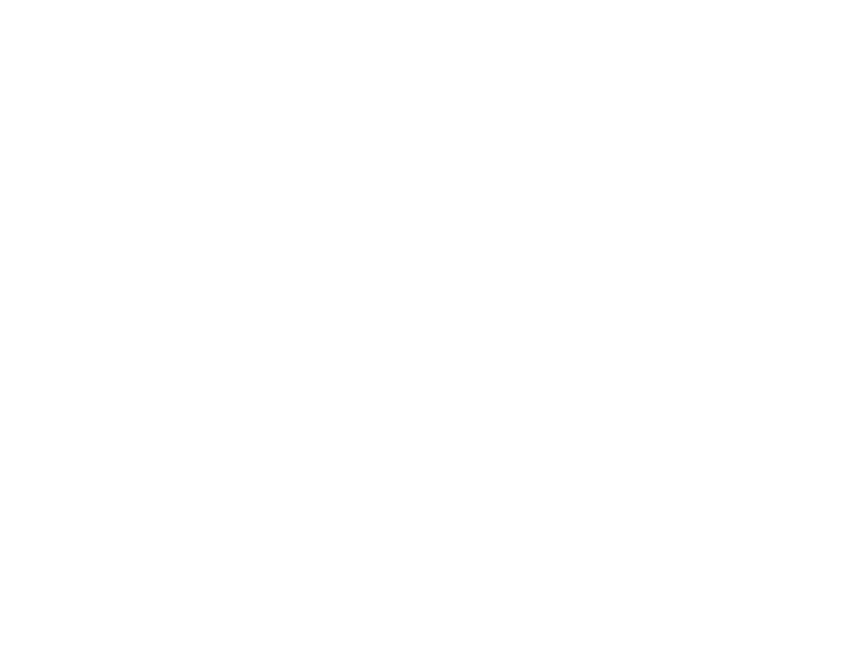

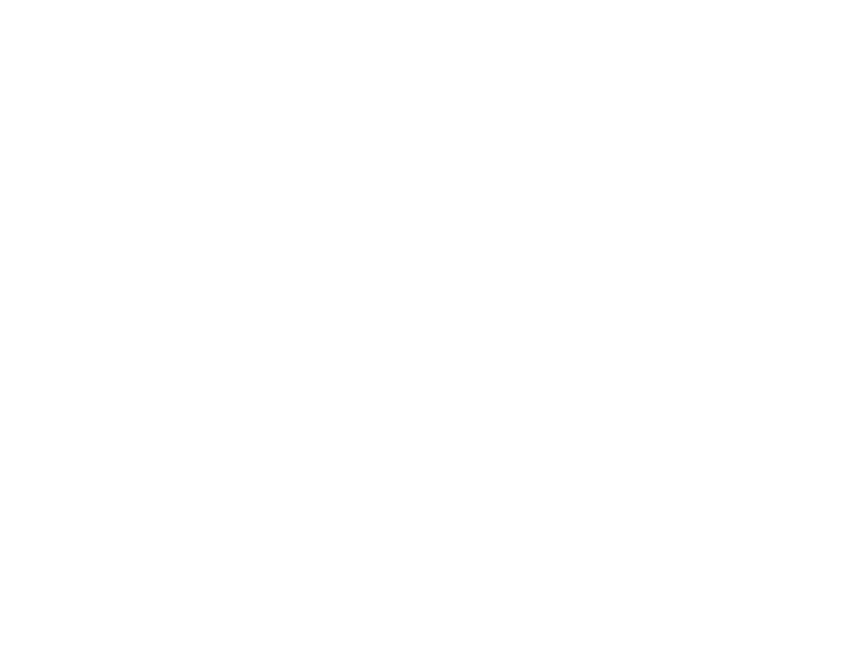

In [2]:
%matplotlib ipympl
Fig3b = Fig(num=3, grid=(4, 4), size=(8.5, 6.5), fontsize=6)  # size=(7.2, 5.3) if not scaling properly
print(Fig3b.fig.get_size_inches())
Fig3bstats = Fig(num="Figure 3b stats", grid=(4, 4), size=(8.5, 6.5), fontsize=6) 
print(Fig3bstats.fig.get_size_inches())
Fig3bcomb = FigMirror(Fig3b, Fig3bstats)

In [3]:
from copy import deepcopy

def add_memory_designations(df_use, before=['-2_-1', '-1_4'], during=['4_1'], after=['1_2', '2_7']):
    """Add in designations for before, 4hr (during), and after ANI administration into your dataframe"""
    df = deepcopy(df_use)
    desig = ["" for a in df.itertuples()]
    
    def create_bool_array_from_list(bool_list):
        bool_out = False
        for b in bool_list:
            bool_out = np.bitwise_or(bool_out, b)
            
        return bool_out
    
    before_bool_list = [df["d1_d2"] == bef for bef in before]
    before_ind = np.where(create_bool_array_from_list(before_bool_list))[0]
    during_bool_list = [df["d1_d2"] == dur for dur in during]
    during_ind = np.where(create_bool_array_from_list(during_bool_list))[0]
    after_bool_list = [df["d1_d2"] == aft for aft in after]
    after_ind = np.where(create_bool_array_from_list(after_bool_list))[0]
    
       # Old hardcoded method below for reference/bug checking
#     before_ind = np.where((df["d1_d2"] == "-2_-1") | (df["d1_d2"] == "-1_4"))[0]
#     during_ind = np.where(df["d1_d2"] == "4_1")[0]
#     after_ind = np.where((df["d1_d2"] == "1_2") | (df["d1_d2"] == "2_7"))[0]
    for idd, d in enumerate(desig):
        if idd in before_ind:
            desig[idd] = "Before"
        elif idd in during_ind:
            desig[idd] = "4hr"
        elif idd in after_ind:
            desig[idd] = "After"

    df['Designation'] = desig
    
    return df

In [4]:
bin_size = 0.5 # sec
all_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                               neurons='all', keep_silent=True)
freeze_silent_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock', 
                                               neurons='freeze_onset', keep_silent=True, base_days=[-2, -1, 4, 1, 2], 
                                               reg_days=[-1, 4, 1, 2, 7], match_event_num=True,
                                               exclude_events='freeze_onset', exclude_buffer=(2, 2))

# Now z-score to baseline days (-2 and -1), add in columns and reorganize a bit
sigz_freeze_df = cova.cov_dict_to_df(freeze_silent_cov, baseline_dict_use=all_cov, include_silent=True)
sigz_freeze_df = add_memory_designations(sigz_freeze_df)

sigz_all_df = cova.cov_dict_to_df(all_cov, baseline_dict_use=all_cov, include_silent=True)
sigz_all_df = add_memory_designations(sigz_all_df)

Marble07: 0it [00:00, ?it/s]


UnboundLocalError: local variable 'CMR' referenced before assignment

In [ ]:
import eraser_reference as err
from copy import copy
def add_in_subject_id(df):
    """Add in mouse ids to dataframe so that you can run mixed anovas. Notebook specific function."""
    df_wid = copy(df)
    mouse_names_use = []
    for names in [err.learners, err.nonlearners, err.ani_mice_good]:
        mouse_names_use.extend(names)
    mouse_id_list = []
    for mid, mname in enumerate(mouse_names_use):
        mouse_id_list.extend([mid]*len(df['d1_d2'].unique()))
    df_wid['Mouse'] = mouse_id_list
    
    return df_wid

In [ ]:
# Plot covariance of each set of cells - Broken into ANI vs Ctrls (grouped Learners and Non-Learners)
ax_sigfrz_cov, ax_sigfrz_cov_stats = Fig3bcomb.subplot(Fig3b.gs[0, 0])
ax_sigall_cov, ax_sigall_cov_stats = Fig3bcomb.subplot(Fig3b.gs[0, 1])

sigz_freeze_df = add_in_subject_id(sigz_freeze_df)
sigz_all_df = add_in_subject_id(sigz_all_df)

cmap_use = plt.get_cmap('Set2').colors[0:3:2]  # Use consistent colormap

for a, astat, title_use, df_use in zip([ax_sigfrz_cov, ax_sigall_cov], [ax_sigfrz_cov_stats, ax_sigall_cov_stats],
                                       ['Freeze Cell Covariance (event # matched)', 
                                        'All Cell Covariance (event # matched)'], 
                                       [sigz_freeze_df, sigz_all_df]):
    # Plot data
    gfg = sns.stripplot(x="Designation", y="cov_z_mean", hue="Group", size=3, palette=cmap_use,
                  data=df_use[~(df_use['Designation'] == '')], dodge=True, ax=a)
    gfg.legend(fontsize=6, markerscale=0.15)
    a.set_title(title_use, fontsize=8)
    a.set_ylabel(r'$\mathregular{\overline{Z}}$', fontsize=8)
    a.set_xlabel('', fontsize=8)
    a.tick_params(axis='both', which='major', labelsize=8, grid_linewidth=1)
    plt.setp(a.spines.values(), linewidth=1)
    sns.despine(ax=a)
    
    # Calculate and plot stats
#     stats_before_after(df_use, 'cov_z_mean', ax=astat, fontsize=6)
    stats_sig = pg.anova(data=df_use[~(df_use['Designation'] == '')], dv='cov_z_mean', 
                         between=['Designation', 'Group'])
    pw_sig = pg.pairwise_tests(data=df_use[~(df_use['Designation'] == '')], padjust='bonf', dv='cov_z_mean', 
                               between=['Group', 'Designation'], parametric=False)
    astat.set_title(title_use)
    astat.text(0.1, 0.7, str(stats_sig), fontdict={'fontsize': 2})
    astat.text(0.1, 0.05, str(pw_sig), fontdict={'fontsize': 2})
    sns.despine(ax=astat, bottom=True, left=True)
    astat.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    
    print(stats_sig)
    print(pw_sig)
    

Now run the above 100 times to generate a distribution of p-values so that you can calculate the average.

In [ ]:
stats_all_cov, stats_freeze_cov = [], []
pw_all_cov, pw_freeze_cov = [], []
niter = 100
for id in range(niter):
    all_cov_ds = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                            neurons='all', keep_silent=True, match_event_num=True,
                                            exclude_events='freeze_onset')
    freeze_silent_cov_ds = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock', 
                                                   neurons='freeze_onset', keep_silent=True, 
                                                   base_days=[-2, -1, 4, 1, 2], 
                                                   reg_days=[-1, 4, 1, 2, 7], match_event_num=True,
                                                   exclude_events='freeze_onset', exclude_buffer=(2, 2))

    # Now z-score to baseline days (-2 and -1), add in columns and reorganize a bit
    sigz_freeze_df_ds = cova.cov_dict_to_df(freeze_silent_cov_ds, baseline_dict_use=all_cov, include_silent=True)
    sigz_freeze_df_ds = add_memory_designations(sigz_freeze_df_ds)

    sigz_all_df_ds = cova.cov_dict_to_df(all_cov_ds, baseline_dict_use=all_cov, include_silent=True)
    sigz_all_df_ds = add_memory_designations(sigz_all_df_ds)

    for df_use, stats_list, pw_list in zip([sigz_freeze_df_ds, sigz_all_df_ds], [stats_freeze_cov, stats_all_cov],
                                           [pw_freeze_cov, pw_all_cov]):
        stats_sig = pg.anova(data=df_use[~(df_use['Designation'] == '')], dv='cov_z_mean', 
                                 between=['Designation', 'Group'])
        pw_sig = pg.pairwise_tests(data=df_use[~(df_use['Designation'] == '')], padjust='bonf', dv='cov_z_mean', 
                                   between=['Group', 'Designation'], parametric=False)
        stats_list.append(stats_sig)
        pw_list.append(pw_sig)
        
                                         

In [ ]:
def make_avg_pw_df(pw_df_list):
    num_inds = [4, 5, 6, 8, 9, 11]
    avg_df = deepcopy(pw_df_list[0])
    for loc in pd.concat(pw_df_list).index.unique():
        avg_df.iloc[loc, num_inds] = pd.concat(pw_df_list).loc[loc].iloc[:, num_inds].mean(axis=0)
    
    return avg_df

In [ ]:
def make_avg_stats_df(stats_df_list):
    num_inds = [1, 2, 3, 4, 5, 6]
    avg_df = deepcopy(stats_df_list[0])
    for loc in pd.concat(stats_df_list).index.unique():
        avg_df.iloc[loc, num_inds] = pd.concat(stats_df_list).loc[loc].iloc[:, num_inds].mean(axis=0)
    
    return avg_df

In [ ]:
# Plot covariance of each set of cells - Broken into ANI vs Ctrls (grouped Learners and Non-Learners)
ax_sigfrz_cov_avg, ax_sigfrz_cov_stats_avg = Fig3bcomb.subplot(Fig3b.gs[1, 0])
ax_sigall_cov_avg, ax_sigall_cov_stats_avg = Fig3bcomb.subplot(Fig3b.gs[1, 1])

cmap_use = plt.get_cmap('Set2').colors[0:3:2]  # Use consistent colormap

for astat, title_use, stats_sig_all, pw_sig_all in zip([ax_sigfrz_cov_stats_avg, ax_sigall_cov_stats_avg],
                                       ['Freeze Cell Covariance (event # matched) - Avg Stats', 
                                        'All Cell Covariance (event # matched)  - Avg Stats'], 
                                       [stats_freeze_cov, stats_all_cov], [pw_freeze_cov, pw_all_cov]):
    astat.set_title(title_use)
    astat.text(0.1, 0.7, str(make_avg_stats_df(stats_sig_all)), fontdict={'fontsize': 2})
    astat.text(0.1, 0.05, str(make_avg_pw_df(pw_sig_all)), fontdict={'fontsize': 2})
    sns.despine(ax=astat, bottom=True, left=True)
    astat.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    
    print(make_avg_stats_df(stats_sig_all))
    print(make_avg_pw_df(pw_sig_all))
    

In [ ]:
make_avg_pw_df(pw_all_cov)



In [ ]:
plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')
Fig3b.savefig(plot_path / 'Figure3_event_matched.pdf', scriptname='Figure3_covariance_event_num_matched.ipynb')
Fig3bstats.savefig(plot_path / 'Figure3_event_matched_stats.pdf', scriptname='Figure3_covariance_event_num_matched.ipynb')